<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/Unit_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install ninja 2>> install.log
git clone https://github.com/SIDN-IAP/global-model-repr.git tutorial_code 2>> install.log

In [ ]:
!git clone https://github.com/anas-awadalla/dissect.git

In [34]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dissect.netdissect import nethook, imgviz, show, segmenter, renormalize, upsample, tally, pbar
torch.cuda.set_device(0)

In [96]:
# Pretrained model
model = torchvision.models.densenet121()
model.classifier = nn.Linear(1024, 7)
d = torch.load("/content/drive/My Drive/Interpretability Experiments/kaggle90-fc.pt")
model.load_state_dict(state_dict=d)

<All keys matched successfully>

In [92]:
# for name, module in model.named_modules():
#     # prune 80% of connections in all 2D-conv layers
#     if isinstance(module, torch.nn.Conv2d):
#         prune.l1_unstructured(module, name='weight', amount=0.8)
#     # prune 40% of connections in all linear layers
#     elif isinstance(module, torch.nn.Linear):
#         prune.l1_unstructured(module, name='weight', amount=0.4)

In [187]:
model = nethook.InstrumentedModel(model)
model.eval()

InstrumentedModel(
  (model): InstrumentedModel(
    (model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _

tensor([[1.8631e-12, 4.5038e-15, 3.6856e-06, 2.8751e-09, 9.9981e-01, 7.4435e-07,
         1.8463e-04]], grad_fn=<SoftmaxBackward>)
Output:  4


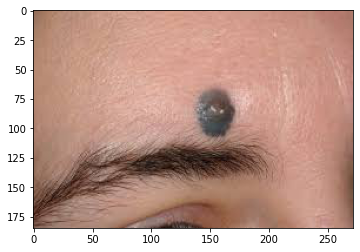

In [168]:
from matplotlib.pyplot import imshow
from PIL import Image
image_path = "/content/images.jpeg" #@param {type: "string"}
ood_img = Image.open(image_path) 

ood_tensor_img = transform(ood_img)

model.cpu().eval()
output = model(ood_tensor_img.unsqueeze(0))
print(torch.softmax(output,dim = 1))
print("Output: ", torch.argmax(output).item())
imshow(ood_img)

In [102]:
import pandas as pd
import glob
import os

#make a dataset
data = pd.read_csv("/content/drive/My Drive/mHealth Privacy/Evaluating Models/Data/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

print(data)
base_skin_dir = os.path.join('/content/drive/My Drive/mHealth Privacy/Evaluating Models/Data/skin-cancer-mnist-ham10000/HAM10000_images_total')


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

data['cell_type'].value_counts()

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


Melanocytic nevi                  6705
dermatofibroma                    1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [7]:
from PIL import Image
class dataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, transform=None):
        'Initialization'
        self.df = df
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = Image.open("/content/drive/My Drive/mHealth Privacy/Evaluating Models/Data/skin-cancer-mnist-ham10000/HAM10000_images_total/"+self.df['image_id'][index]+".jpg")
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [8]:
transform=transforms.Compose([
            transforms.Resize((224 ,224)),
            transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

ham_data = dataset(data, transform=transform)
dataloader_imgs = DataLoader(ham_data, batch_size=100,shuffle=True)

In [9]:
torch.cuda.empty_cache()

In [10]:
itr = iter(dataloader_imgs)

In [12]:
batch = next(itr)

In [35]:
iv = imgviz.ImageVisualizer((256, 256), source=ham_data, percent_level=0.99)

In [36]:
ivsmall = imgviz.ImageVisualizer((56, 56), source=ham_data, percent_level=0.99)

In [174]:
model.cuda();


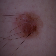
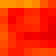
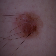
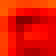
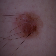
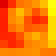
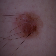
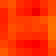
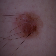
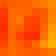
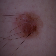
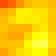
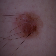
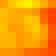
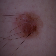
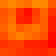
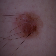
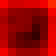
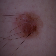
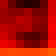
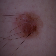
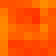
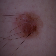
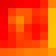
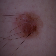
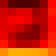
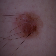
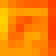
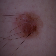
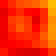
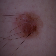
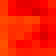
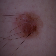
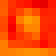
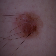
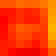
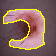
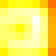
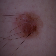
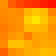
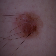
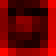
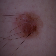
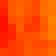
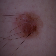
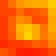
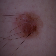
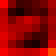
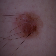
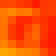
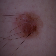
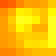
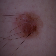
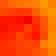
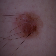
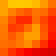
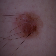
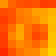
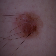
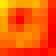
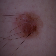
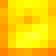
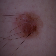
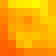

In [43]:
layername = 'features.denseblock4.denselayer2.conv2'
model.retain_layer(layername)
data, y = batch
model(data.cuda())
acts = model.retained_layer(layername).cpu()

# for unitnum in range(acts.shape[1]):
#     for imagenum in [0]:
#       img = ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)
#       heat = ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')
#       img.
show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'Unit %d' % unitnum,
        'Class %d' % y[imagenum].item()
    ]
    for unitnum in range(acts.shape[1])
    for imagenum in [0]
])

In [190]:
sample_size = 100
layername = 'features.denseblock1.denselayer2.conv2'
model.retain_layer(layername)
data, y = batch
def max_activations(batch, *args):
    image_batch = data.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).max(2)[0]

def mean_activations(batch, *args):
    image_batch = data.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).mean(2)

topk = tally.tally_topk(
    mean_activations,
    dataset=ham_data,
    sample_size=sample_size,
    batch_size=100,
    cachefile='results/cache_mean_topk.npz'
)

top_indexes = topk.result()[1]

ValueError: ignored

In [185]:
print(model.retained_layer(layername).shape)

torch.Size([100, 64, 112, 112])



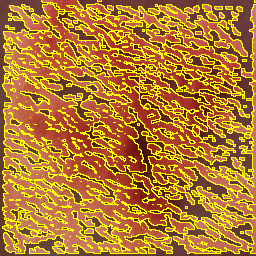
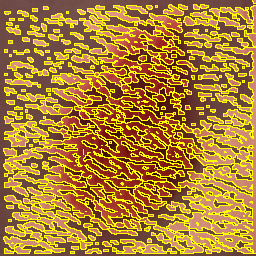
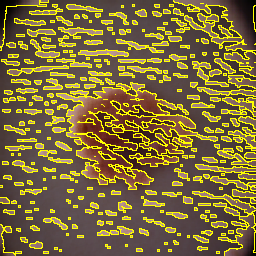
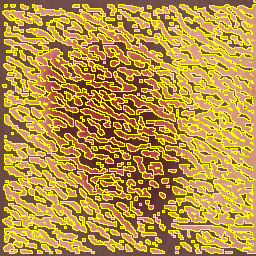
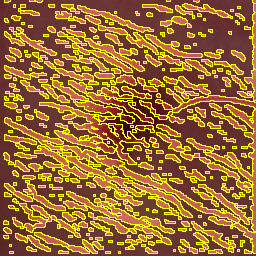
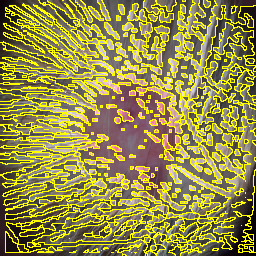
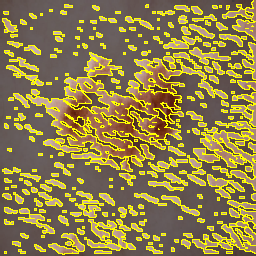
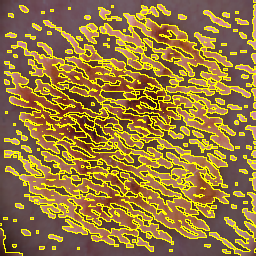
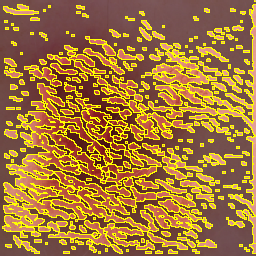
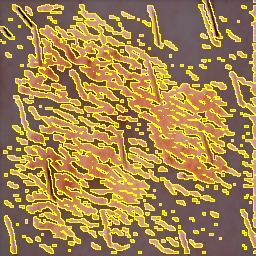

In [186]:
show.blocks([
      ['unit %d' % u,
       layername ,
      'img %d' % i,
      'pred: %s' % batch[1][i].item(),
      [iv.masked_image(
          batch[0][i],
          model.retained_layer(layername)[i],
          u,level=0)]
      ]
    for u in [62]
    for i in top_indexes[u, :10]
])

In [158]:
model.stop_retaining_layers([layername])

In [159]:
model.retain_layer(layername)

In [181]:
output = model(ood_tensor_img.unsqueeze(0).cuda());


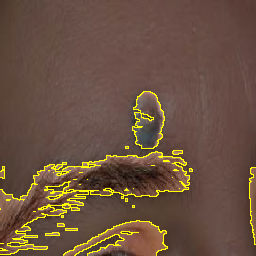

In [182]:
show.blocks([
      ['unit %d' % u,
      'pred: %s' % torch.argmax(output).item(),
      [iv.masked_image(
          ood_tensor_img,
          model.retained_layer(layername)[0],
          u,level=0)]
      ]
    for u in [12]
    # for i in top_indexes[u, :8]
])